In [1]:
# /scratch2/personal/pteng/dataset/rawlung/RESEARCH/dcm/102651630/img_1.dcm
# /scratch2/personal/pteng/dataset/rawlung/RESEARCH/image/102651630.nii.gz
# /scratch2/personal/pteng/dataset/rawlung/RESEARCH/mask/102651630.nii.gz

In [2]:
import os, sys
import numpy as np
import pandas as pd
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import SimpleITK as sitk

def imread(fpath):
    if fpath.endswith('.list'):
        with open(fpath,'r') as f:
            dicom_names = [x for x in f.read().split('\n') if len(x) > 0]
        if not os.path.exists(dicom_names[0]):
            dicom_names = [os.path.join(os.path.dirname(fpath),x) for x in dicom_names]
        reader = sitk.ImageSeriesReader()
        reader.SetFileNames(dicom_names)
    else:
        reader= sitk.ImageFileReader()
        reader.SetFileName(fpath)
    img = reader.Execute()
    arr = sitk.GetArrayFromImage(img)    
    spacing = img.GetSpacing()
    origin = img.GetOrigin()
    direction = img.GetDirection()    
    return arr,spacing,origin,direction

def imwrite(fpath,arr,spacing,origin,direction,use_compression=True):
    img = sitk.GetImageFromArray(arr)
    img.SetSpacing(spacing)
    img.SetOrigin(origin)
    img.SetDirection(direction)
    writer = sitk.ImageFileWriter()    
    writer.SetFileName(fpath)
    writer.SetUseCompression(use_compression)
    writer.Execute(img)


In [4]:
#img_file = '/scratch2/personal/pteng/dataset/rawlung/RESEARCH/image/102651630.nii.gz'
#mask_file = '/scratch2/personal/pteng/dataset/rawlung/RESEARCH/mask/102651630.nii.gz'
img_file = 'image.nii.gz'
mask_file = 'mask.nii.gz'

In [5]:
!ls 

Dockerfile  Untitled.ipynb  mask.nii.gz       viz-fiss.ipynb
README.md   image.nii.gz    requirements.txt


In [6]:
img,spacing,origin,direction = imread(img_file)
mask,_,_,_ = imread(mask_file)

In [7]:
img.dtype

dtype('int16')

In [8]:
print(img.shape,mask.shape)
print(spacing,origin,direction)

(559, 512, 512) (559, 512, 512)
(0.6796875, 0.6796875, 0.5) (-164.66015625, -333.16015625, 1210.0) (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, -1.0)


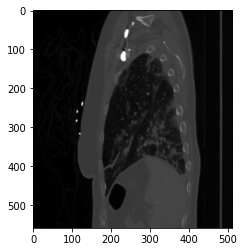

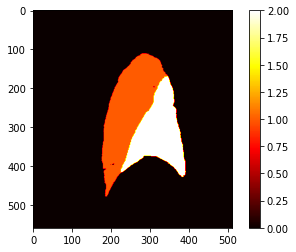

In [9]:
plt.figure(0)
plt.imshow(img[:,:,256+128],cmap='gray')
plt.figure(1)
plt.imshow(mask[:,:,256+128],cmap='hot')
plt.colorbar()

In [21]:
np.unique(mask)

array([0, 1, 2, 3, 4, 5], dtype=int16)

In [10]:
tmp = np.sum(img,axis=0)
print(tmp.shape)

(512, 512)


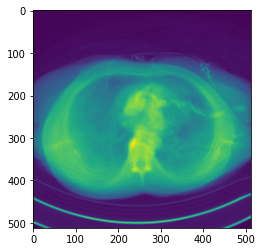

In [14]:
plt.imshow(tmp)

In [62]:
def process(mask,ind0,ind1):
    lobe0 = mask==ind0
    lobe0 = ndi.binary_dilation(lobe0,iterations=3)
    lobe0 = lobe0.astype(int)

    lobe1 = mask==ind1
    lobe1 = ndi.binary_dilation(lobe1,iterations=3)
    lobe1 = lobe1.astype(int)

    assumed_fissure_location = ((lobe0+lobe1)==2)

    dimg = ((img.astype(np.float)+1000)/(2000)).clip(0,1)
    dimg[assumed_fissure_location==0]=0
    
    summed = np.nansum(dimg,axis=0)
    # poor mans derivative image
    tmpZ = ndi.sobel(dimg,axis=0,mode='nearest',cval=0)
    tmpX = ndi.sobel(dimg,axis=1,mode='nearest',cval=0)
    tmpY = ndi.sobel(dimg,axis=2,mode='nearest',cval=0)
    sobeled = np.nansum(tmpZ+tmpX+tmpY,axis=0)
    
    return summed,sobeled

mylist = [
    (1,2),
    (3,4),
    (4,5),
    (3,5),
]
mydict = {}
for n,key in enumerate(mylist):
    ind0,ind1 = key
    mydict[key]=process(mask,ind0,ind1)

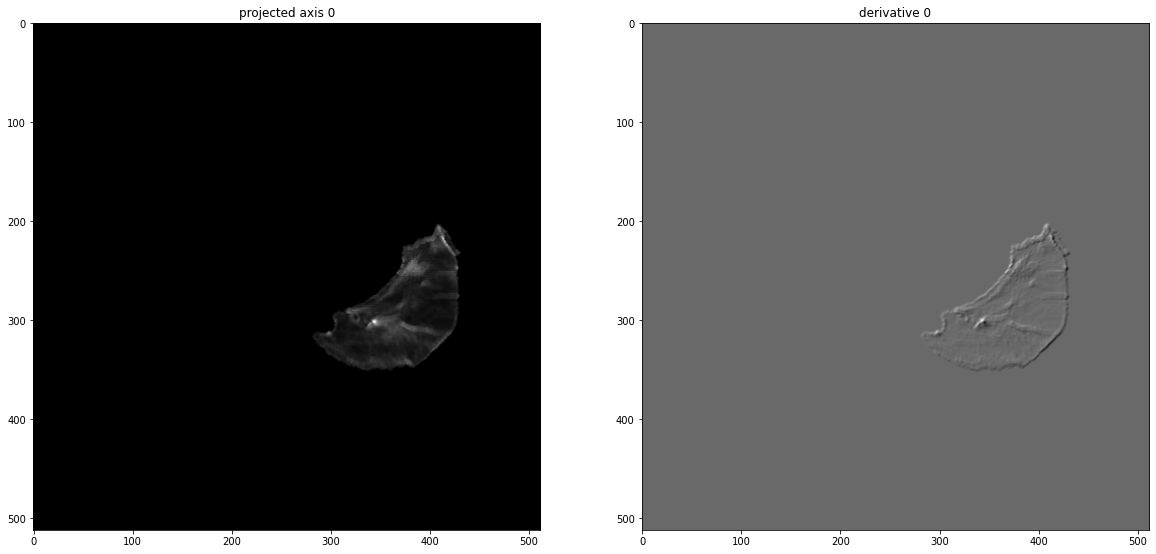

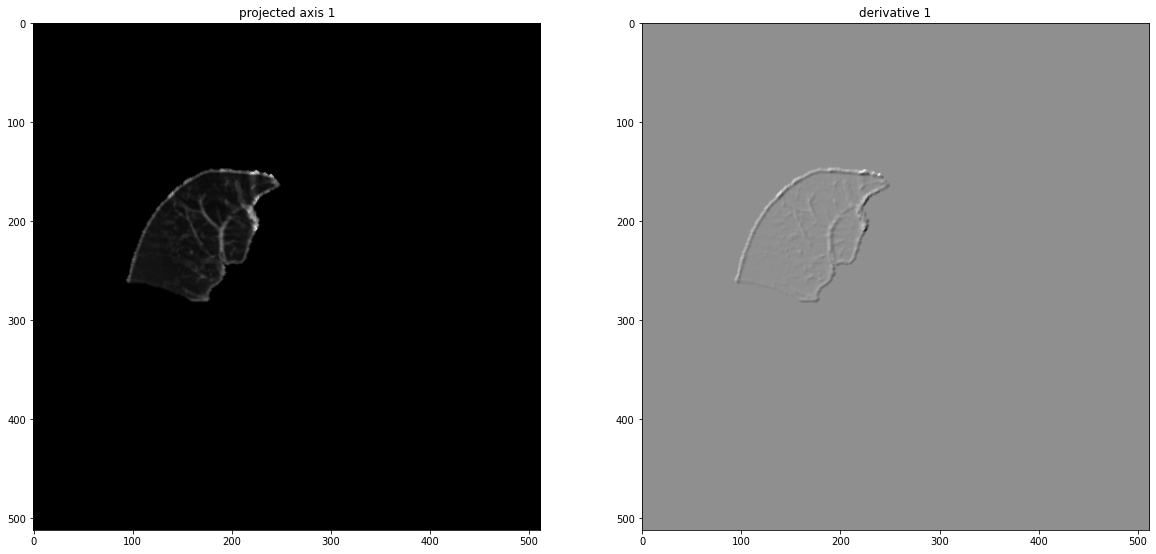

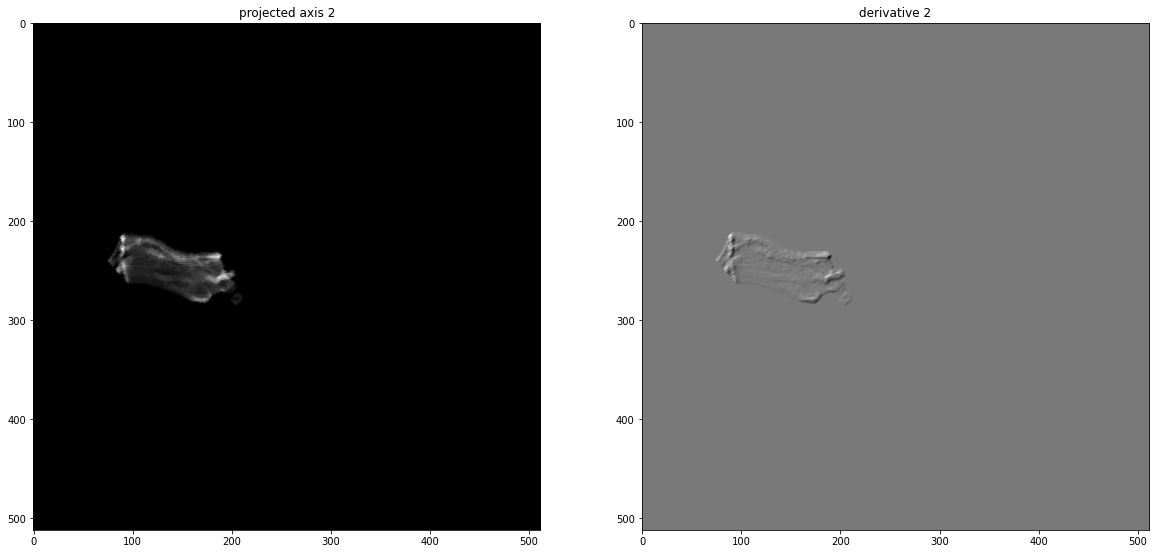

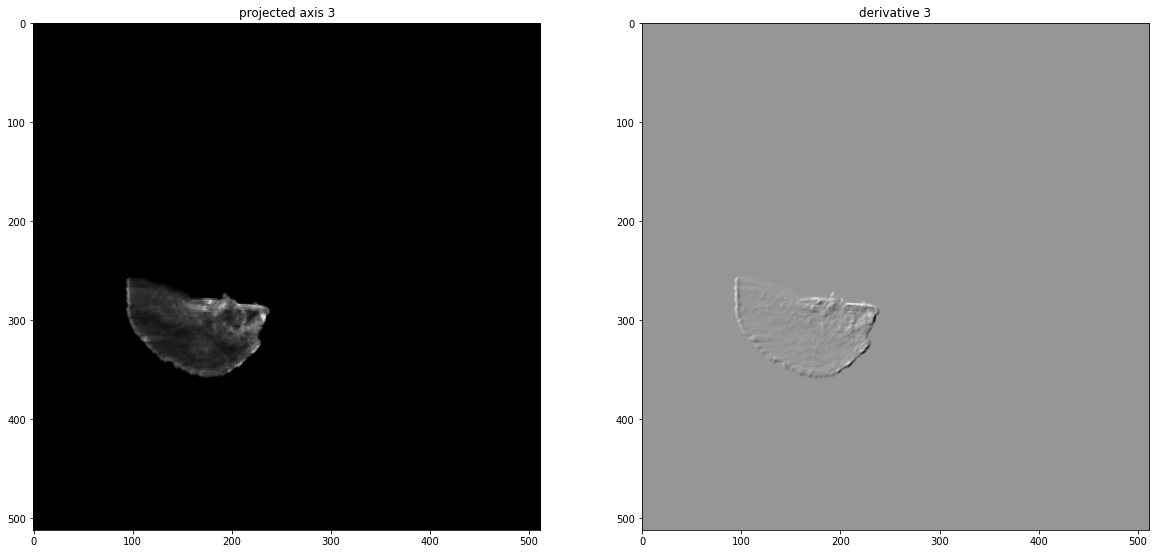

In [64]:
for n,k in enumerate(mydict.keys()):
    projected,sobeled = mydict[k]
    plt.figure(n,figsize=(20,10))
    plt.subplot(121)
    plt.title(f"projected axis {n}")
    plt.imshow(projected,cmap='gray')
    plt.subplot(122)
    plt.imshow(sobeled,cmap='gray')
    plt.title(f"derivative {n}")

In [65]:
ind0,ind1 = (1,2)

lobe0 = mask==ind0
lobe0 = ndi.binary_dilation(lobe0,iterations=3)
lobe0 = lobe0.astype(int)

lobe1 = mask==ind1
lobe1 = ndi.binary_dilation(lobe1,iterations=3)
lobe1 = lobe1.astype(int)

assumed_fissure_location = ((lobe0+lobe1)>1)

dimg = ((img.astype(np.float)+1000)/(2000)).clip(0,1)
dimg[assumed_fissure_location==0]=0

summed = np.nansum(dimg,axis=0)
# poor mans derivative image
tmpZ = ndi.sobel(dimg,axis=0,mode='nearest',cval=0)
tmpX = ndi.sobel(dimg,axis=1,mode='nearest',cval=0)
tmpY = ndi.sobel(dimg,axis=2,mode='nearest',cval=0)
sobeled = np.nansum(tmpZ+tmpX+tmpY,axis=0)



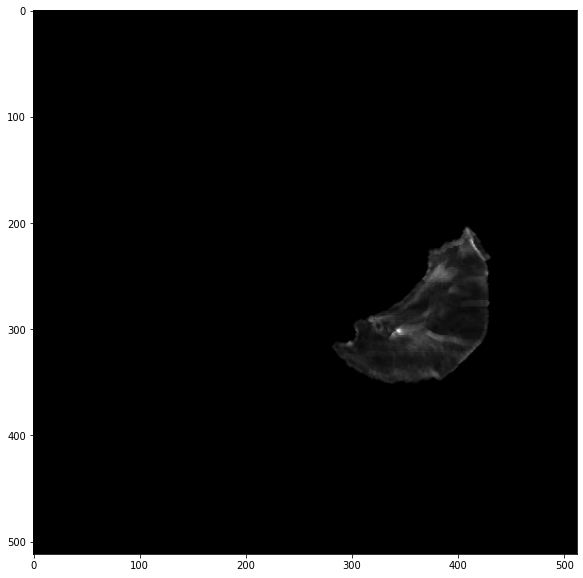

In [66]:
plt.figure(figsize=(10,20))
plt.subplot()
plt.imshow(summed,cmap='gray')

plt.figure(figsize=(10,10))
plt.imshow(sobeled,cmap='gray')